# Imports and Setup

In [88]:
import pandas as pd
import random
import re
from pathlib import Path
from datetime import datetime

import spacy
from spacy import displacy
from spacy.scorer import Scorer
from spacy.tokens import DocBin
from spacy.training import Example
from spacy.util import minibatch, compounding
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [89]:
# Paths
DATA_DIR = Path('../data')
CLEANED_PATH = DATA_DIR / 'postings_cleaned.csv'
LABELED_PATH = DATA_DIR / "postings_cleaned_w_skills.csv"
MODEL_DIR = Path("../models/ner_skill_model")

# Seed for reproducibility
random.seed(42)

# Load and Clean data

In [90]:
postings = pd.read_csv(CLEANED_PATH)
postings.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,level_director,level_principal,level_vice_president,level_chief,level_intern,level_junior,original_listed_time_ts,listed_time_ts,closed_time_ts,time_open
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,False,False,False,False,False,False,2024-04-17 23:45:08,2024-04-17 23:45:08,NaN,NaN
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,False,False,False,False,False,False,2024-04-11 17:51:27,2024-04-11 17:51:27,NaN,NaN
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,False,False,False,False,False,False,2024-04-16 14:26:54,2024-04-16 14:26:54,NaN,NaN
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,False,False,False,False,False,False,2024-04-12 04:23:32,2024-04-12 04:23:32,NaN,NaN
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,False,False,False,False,False,False,2024-04-18 14:52:23,2024-04-18 14:52:23,NaN,NaN


# Create custom "SKILL" NER model

## Create weakly-labeled training data set

I am personally familiar with software, data scientist and bioscientist roles, so rather than manually label the dataset postings, I will create a list of known skills for these roles and weakly label a subset of data and bioscientist postings to provide to the model for training.

In [77]:
def weak_label_skills(text, skill_list):
    matches = []
    for skill in skill_list:
        for m in re.finditer(rf"\b{skill}\b", text, flags=re.IGNORECASE):
            matches.append((m.start(), m.end(), "SKILL"))
    return matches

In [79]:
general_skills = [
    "microsoft office", 'teamwork', 'collaboration', 'communication', 'attention to detail', 
    'critical thinking', 'problem-solving', 'project management', 
]

software_skills = [
    "python", "java", "sql", "javascript", "html", "css", "ruby", "spark",
    "pyspark", "nosql", "mongodb", "hadoop", "postgresql",
    "docker", "aws", "azure", "adobe", "jira", "databricks", "dbt",
    "excel", "object-oriented programming"
]

datascience_skills = [
    "machine learning", "data analysis",  "deep learning", "feature extraction", 
    "statistics", "statistical analysis", "probability", "experimental design",
    "neural networks", "lightgbm", "xgboost", "catboost", "pytorch", "tensorflow", "keras",
    "scikit-learn", "spacy", "nltk", "vader", "pandas", "numpy", "matplotlib",
    "nlp", "natural language processing", "text mining", "text analysis",
    "genai", "openai", "generative ai", "claude", "llama", "chatgpt", "langchain"
]

datavis_skills = [
    "data visualization", "tableau", "powerbi", "power bi", "looker", "plotly", 
    "qlik sense", "d3.js", "domo", "zoho analytics", "Sisense"
]

scientist_skills = [
    "PCR", "Western blot", "flow cytometry", "CRISPR", "GraphPad Prism", "prime editing",
    "Illumina", "cell culture", "next-generation sequencing", "ngs", "molecular cloning",
    "gene editing", "ELISA", "bioconjugation", "protein purification", "yeast display", "genious",
    "snapgene", "ChimeraX", "pymol", "crispresso2", "polymerase chain reaction", "electrophoresis"
]


SKILLS_LIST = list(set(general_skills + software_skills + datascience_skills + datavis_skills + scientist_skills))

In [80]:
bootstrap_skills_set = postings[
    ( postings['title_normalized'].str.contains("engineer", na=False) )
    | ( postings['title_normalized'].str.contains("scientist", na=False) )
    | ( postings['title_normalized'].str.contains("analyst", na=False) )

]
print(f"{len(bootstrap_skills_set)} matching engineer, scientist, or analyst postings")

14897 matching engineer, scientist, or analyst postings


In [81]:
matching_postings = []

# shuffle to remove any ordering/sorting bias (in which kinds of jobs end up in training set)
bootstrap_skills_set = bootstrap_skills_set.sample(frac=1)

for description in bootstrap_skills_set['description'].dropna().unique():
    entity_list = weak_label_skills(description, SKILLS_LIST)
    if len(entity_list) > 0:
      matching_postings.append((description, {"entities": entity_list}))

split_index = 1000
TRAIN_DATA = matching_postings[:split_index]
TEST_DATA = matching_postings[split_index:split_index+1000]

print(f"generated {len(TRAIN_DATA)} training examples, {len(TEST_DATA)} test examples")

generated 1000 training examples, 1000 test examples


## Initialize and train NER model

In [91]:
import warnings
warnings.filterwarnings("ignore")

nlp = spacy.load("en_core_web_lg")
ner = nlp.get_pipe("ner")
ner.add_label("SKILL")

examples = []
for text, annots in TRAIN_DATA:
    doc = nlp.make_doc(text)
    example = Example.from_dict(doc, annots)
    examples.append(example)

n_iter = 10 
dropout = 0.2
batch_size = 8

optimizer = nlp.create_optimizer()

losses_list = []

for i in tqdm(range(n_iter)):
    random.shuffle(examples)
    losses = {}
    batches = minibatch(examples, size=batch_size)
    for batch in batches:
        nlp.update(batch, sgd=optimizer, drop=dropout, losses=losses)
    losses_list.append(losses.get("ner", 0))


  0%|          | 0/10 [00:00<?, ?it/s]

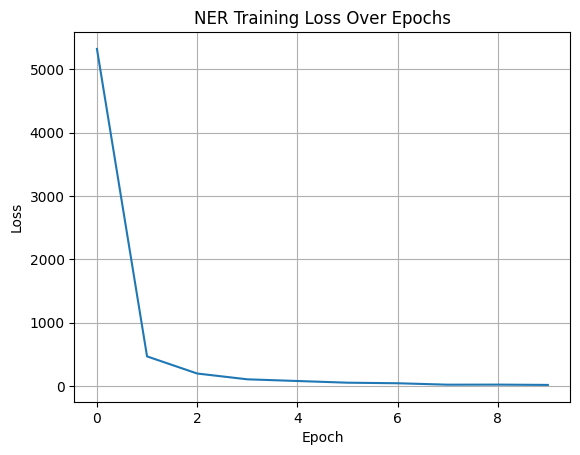

In [92]:
plt.plot(losses_list)
plt.title("NER Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [93]:
def evaluate(nlp_model, data):
    scorer = Scorer()
    examples = []
    for text, annotations in data:
        doc = nlp_model(text)
        example = Example.from_dict(doc, annotations)
        examples.append(example)

    return scorer.score(examples)

scores = evaluate(nlp, TEST_DATA)
scores["ents_p"], scores["ents_r"], scores["ents_f"]

(0.9972807613868117, 0.9968289920724802, 0.9970548255550522)

In [96]:
test_text = "We need someone fluent in Python, R, and SQL. Experience with data visualization tools like Tableau, Power BI, or Chartviz a plus."
doc = nlp(test_text)

print([(ent.text, ent.label_) for ent in doc.ents])

[('Python', 'SKILL'), ('SQL', 'SKILL'), ('data visualization', 'SKILL'), ('Tableau', 'SKILL'), ('Power BI', 'SKILL')]


In [97]:
MODEL_DIR.mkdir(parents=True, exist_ok=True)
nlp.to_disk(MODEL_DIR)

# Extract skills from postings data with new NER model


In [61]:
nlp = spacy.load(MODEL_DIR)

In [94]:
def extract_skills(nlp, text):
    doc = nlp(text)
    skills = [ent.text for ent in doc.ents if ent.label_ == "SKILL"]
    return list(set(skills))

In [ ]:
from tqdm import tqdm

extracted_skills = []
texts = postings['description'].str.lower().tolist()

print(f"starting now: {datetime.now().strftime('%m/%d %H:%M:%S')}")

for text in tqdm(nlp.pipe(texts, batch_size=1000, n_process=1), total=len(texts)):
    doc = nlp(text)
    skills = list(set([ent.text for ent in doc.ents if ent.label_ == "SKILL"]))
    extracted_skills.append(skills)

print(f"finished: {datetime.now().strftime('%m/%d %H:%M:%S')}")

starting now: 10/27 15:50:41


  2%|▌                                  | 1863/107828 [04:14<2:18:28, 12.75it/s]

In [ ]:
postings['extracted_skills'] = extracted_skills
postings.head()

In [ ]:
len(postings)

In [ ]:
postings_with_skills = postings.copy()
postings_with_skills.to_csv(LABELED_FILE, index=False)

## Visualize skill distribution

In [44]:
postings_with_skills = pd.read_csv(LABELED_FILE)

In [56]:
import ast

all_skills_list = []
for posting in postings_with_skills['extracted_skills']:
    posting_skills = ast.literal_eval(posting)
    all_skills_list.extend(posting_skills)
skill_counts = pd.Series(all_skills_list).value_counts()

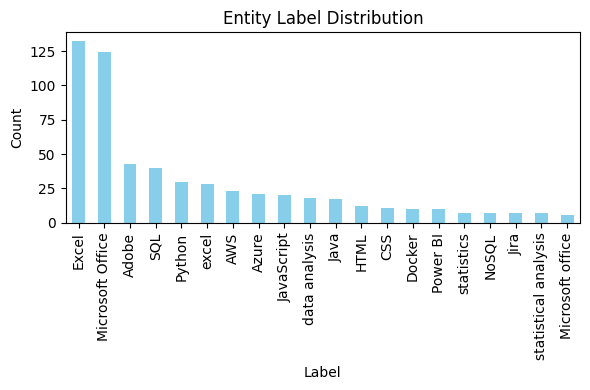

In [60]:
# Skill distribution visualization
plt.figure(figsize=(6,4))
skill_counts[:20].plot(kind='bar', color='skyblue')
plt.title("Entity Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()